In [1]:
#Define some libraries to plot and calculate values
import matplotlib.pyplot as plt
import numpy as np

import cmath

In [2]:
#Random seed generated to have generate random points for the reference data
np.random.seed(42)

#MSE loss to calculate the loss value between prediction and target.
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss = loss + (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [3]:
r = 3 # number of times the encoding gets repeated (here equal to the number of layers)

degree = 3 # degree of the target function
scaling = 1 # scaling of the data
coeffs = [0.15 + 0.15j]*degree # coefficients of non-zero frequencies
coeff0 = 0.1 # coefficient of zero frequency

def target_function(x):
    """
        Generate a truncated Fourier series of degree, where the data gets re-scaled.
        Args:
            x(numpy.ndarray([np.float64])) : the data points.
        
        Returns:
            numpy.ndarray([np.float64]): The real part of the complex array
    """
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = complex(0, scaling*(idx+1)*x)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

In [4]:
from pathlib import Path

In [5]:
#Create file if not exist, else give information
def create_File(directory_path):
    # Check if the directory does not exist before creating it
    path = Path(directory_path)
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Directory {directory_path} created successfully.")
    else:
        print(f"Directory {directory_path} already exists.")

Directory ./part1 already exists.


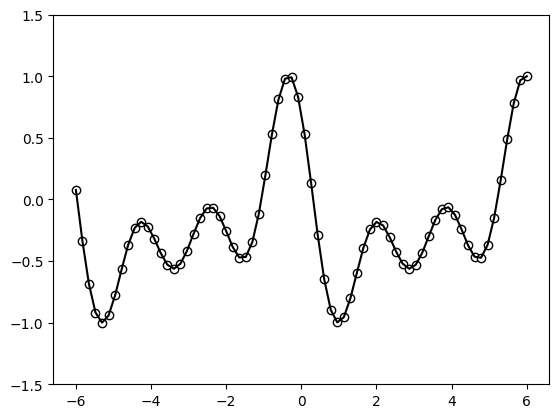

In [6]:
#Used for only rescaling the target_y purposes
from sklearn.preprocessing import MinMaxScaler

data_size = 70

x = np.linspace(-6, 6, data_size)

data = np.array([target_function(x_) for x_ in x])

# Reshape the data to make it 2D
data = data.reshape(-1, 1)

# Create a MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on your data and transform it
target_y = scaler.fit_transform(data).flatten()

#Print outs the corresponding graph
plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-(degree/2), (degree/2))

directory_path = "./part1"

create_File(directory_path)
plt.savefig("./part1/test.png")
plt.show()

## Define a Serial Quantum Model

In [7]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp


class QDevice:
    """
    A class representing the Unitary matrix U(x) = W^(L+1) * S(x) * ... W^2 * S(x) * W^1.
    This structure used to represent specific class of function as Fourier Series.

    Attributes:
        wires(integer) : represent the number of qubits.
        qc (qiskit.circuit.QuantumCircuit): Circuit to run
    """
    def __init__(self, wires=1):
        """
        Initializes an QDevice object.

        Parameters:
            wires(integer) : represent the number of qubits.
            qc (qiskit.circuit.QuantumCircuit): Circuit to run
        """
        self.wires = wires
    
        self.qc = QuantumCircuit(self.wires, self.wires)
    
    def run(self, weights, x=None):
        """
        Run the circuit to have expectation values.
        
        Parameters:
            weights (np.ndarray([np.float64])) : weights to optimize. They should have specific shape ((r+1), 3) where r represent number of repetition in the circuit and 3 is used specifically for the angles of the qiskit.circuit.library.UGate.

            x (np.float64) : specific data point

        Returns:
            np.float64 : observed value from the circuit using pauli-Z Gate
        """
        self.qc = QuantumCircuit(self.wires, self.wires)
        for theta in weights[:-1]:
            self.W(theta)
            self.S(x)
        
        # L+1'th unitary
        self.W(weights[-1])
        
        return self.observe_wire(wires=0)
    
    
    #Used to observe the wires equivalent of qml.expval(qml.PauliZ)
    #Should change to more general version of Pauli matrix as observable
    #using this link https://qiskit.org/ecosystem/ibm-runtime/tutorials/how-to-getting-started-with-estimator.html
    #Function differs from the model why?shifted to the top
    def observe_wire(self, wires=0, observable=(QuantumCircuit.z, 0)):
        """
        Calculates the expectation value of the observable

        Parameters:
            
        """
        observable = SparsePauliOp("Z")
        estimator = Estimator()
        
        job = estimator.run(self.qc, observable)
        result = job.result()
        
        return result.values[0]
        
    #Need to do more general implementation with the possibility of choosing gates
    def S(self, x, wires=0):
        """Data encoding circuit block."""
        self.qc.rx(scaling*x, wires)
    
    def W(self, theta, wires=0):
        """Trainable circuit block."""
        self.qc.u(theta[0], theta[1], theta[2], wires)
        
    def draw(self):
        # Draw the circuit
        #return self.qc.draw('mpl')
        diagram = circuit_drawer(self.qc, output='text')
        print(diagram)

    def save_circuit_image(self, filename:str):
        self.qc.draw('mpl', filename=filename)
    
qt = QDevice(1)
#qt.run([[1,2,3]])
#qt.draw()

In [8]:
qt.S(1)
qt.W([1,2,3])
qt.draw()


     ┌───────┐┌──────────┐
  q: ┤ Rx(1) ├┤ U(1,2,3) ├
     └───────┘└──────────┘
c: 1/═════════════════════
                          


<class 'numpy.float64'>
(70,)


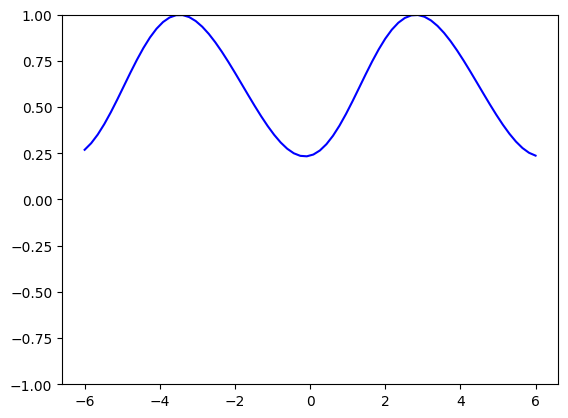

In [9]:
weights = 2*np.pi*np.random.random(size=(r+1, 3)) # some random initial weights

#x = np.linspace(-6, 6, data_size)

#test_x = x.tolist()[70:]
#x = np.array(x.tolist()[:70])

print(type(x[0]))
print(x.shape)
random_quantum_model_y = [qt.run(weights, x=x_) for x_ in x]

init_weights = random_quantum_model_y

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [10]:
qt.draw()
maxiter = 60

directory_path = "./part1/Circuits"
create_File(directory_path)
qt.save_circuit_image('./part1/Circuits/r={}&degree={}_maxiter={}_qc.png'.format(r, degree, maxiter))

     ┌─────────────────────────┐┌───────┐┌───────────────────────────┐┌───────┐»
  q: ┤ U(2.3533,5.9735,4.5993) ├┤ Rx(6) ├┤ U(3.7615,0.98029,0.98014) ├┤ Rx(6) ├»
     └─────────────────────────┘└───────┘└───────────────────────────┘└───────┘»
c: 1/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌──────────────────────────┐┌───────┐┌─────────────────────────┐
«  q: ┤ U(0.36495,5.4423,3.7769) ├┤ Rx(6) ├┤ U(4.449,0.12934,6.0941) ├
«     └──────────────────────────┘└───────┘└─────────────────────────┘
«c: 1/════════════════════════════════════════════════════════════════
«                                                                     
Directory ./part1/Circuits created successfully.


C:\Users\batuh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [11]:
from qiskit.algorithms.optimizers import ADAM as AdamOptimizer
from scipy.optimize import minimize

def cost(w, x, y):
    #print("Weights in cost func: {}".format(weights))
    w=np.reshape(w, w_shape)
    #print("REWeights in cost func: {}".format(weights.shape))

    predictions = [qt.run(w, x=x_) for x_ in x]
    return square_loss(y, predictions)

w_shape = weights.shape

max_steps = 1
lr = 0.3

opt = AdamOptimizer(maxiter=maxiter, lr=lr)
batch_size = 25
#cst = [cost(weights, x, target_y)]  # initial cost
cst = []

for step in range(max_steps):
    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    #print("Shape of x: {}".format(x_batch.shape))
    #print("Shape of y: {}".format(y_batch.shape))
    #print("Shape of w: {}".format(np.sum(weights,axis=1)))
    

    #print("Weifgts before min: \n{}".format(weights))
    
    # Update the weights by one optimizer step
    res = opt.minimize(lambda w: cost(w, x, target_y), weights.reshape(-1), cst=cst)
    
    weights = res.x

    #print("Weights after minimize {}".format(weights))

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    #cst.append(c)
    #if (step + 1) % 10 == 0:
    print("Cost at step {0:3}: {1}".format(step + 1, c))

C:\Users\batuh\AppData\Local\Temp\ipykernel_17380\3648739572.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM as AdamOptimizer


TypeError: ADAM.minimize() got an unexpected keyword argument 'cst'

In [ ]:
qt.draw()

directory_path = "./part1/Circuits"
create_File(directory_path)
qt.save_circuit_image('./part1/Circuits/r={}&degree={}_maxiter={}_qc_after_optimize.png'.format(r, degree,maxiter))

     ┌─────────────────────────┐┌───────┐┌───────────────────────────┐┌───────┐»
  q: ┤ U(4.1607,4.1927,4.5993) ├┤ Rx(6) ├┤ U(4.6573,1.1215,-0.21498) ├┤ Rx(6) ├»
     └─────────────────────────┘└───────┘└───────────────────────────┘└───────┘»
c: 1/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌──────────────────────────┐┌───────┐┌──────────────────────────┐
«  q: ┤ U(-0.84796,3.701,2.0905) ├┤ Rx(6) ├┤ U(4.0169,-3.2894,5.4121) ├
«     └──────────────────────────┘└───────┘└──────────────────────────┘
«c: 1/═════════════════════════════════════════════════════════════════
«                                                                      


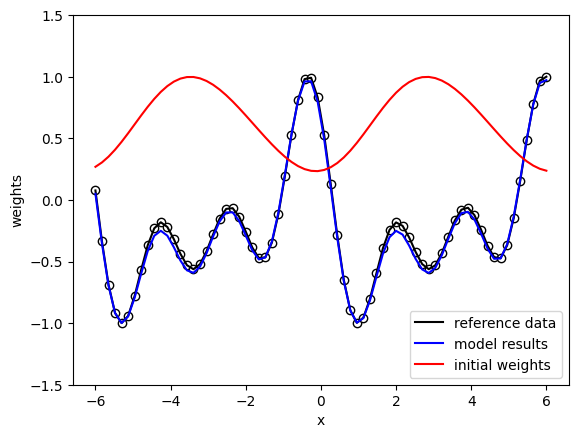

In [ ]:
weights = np.reshape(weights, w_shape)
predictions = [qt.run(weights, x=x_) for x_ in x]


plt.plot(x, target_y, c='black', label = 'reference data')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue', label = 'model results')
plt.plot(x, init_weights, c='r', label = 'initial weights')
plt.ylim(-degree/2, degree/2)
# Add labels and a legend
plt.xlabel('x')
plt.ylabel('weights')
plt.legend()
plt.show()

In [ ]:
print(cst)

[0.9877952571170546, 0.7023714337845903, 0.7100839954140954, 0.5429959801426459, 0.48247006471566045, 0.4647507568467057, 0.4170627887368656, 0.4028707205144412, 0.3574180055869472, 0.25589438188788977, 0.2586504612465681, 0.30056692657870476, 0.2997202167522058, 0.2517498629864028, 0.19482826345766552, 0.17230602148599516, 0.17376732224578703, 0.17272847796109567, 0.13901507261300505, 0.09815828768193634, 0.1010276645948267, 0.11446895717418393, 0.12422560299728168, 0.12133983543496904, 0.12372815197300698, 0.13596200577093948, 0.14295592849803965, 0.14033539628115924, 0.11990890271424962, 0.09708557425117237, 0.09045625637598727, 0.09384126969140795, 0.09038874237420332, 0.08422111587149825, 0.07776283855534186, 0.07768821574396022, 0.0801887053418418, 0.08442290409859377, 0.08239132146447602, 0.07212241311234202, 0.05613686541547988, 0.044157000859952326, 0.04379225541209321, 0.045771424242854804, 0.04742566483083918, 0.048090945636763915, 0.051909550370465914, 0.0577436984988239, 0

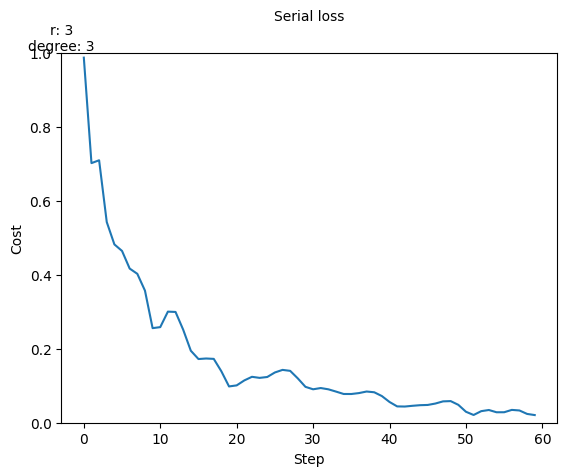

In [ ]:
# Annotate with extra information
extra_info = f'r: {r}\ndegree: {degree}'
plt.annotate(extra_info, xy=(0, 1), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')
extra_info = 'Serial loss'
plt.annotate(extra_info, xy=(0.5, 1.1), xycoords='axes fraction', fontsize=10, ha='center', va='center')

#plt.yscale('log')
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 1)

directory_path = "./part1/Loss_Func_Graphs"
create_File(directory_path)
plt.savefig("./part1/Loss_Func_Graphs/serial_loss_attributes_r={}_degree={}_step={}_maxiter={}.png".format(r, degree,max_steps, maxiter))
plt.show()

In [ ]:
print(type(cst))

<class 'list'>


In [ ]:
def write_attributes_to_file(attributes, filename):
    # Write each attribute on a new line
    with open(filename, 'w') as file:
        for key, value in attributes.items():
            file.write(f"{key}: {value}\n")

def read_attributes_from_file(filename):
    # Read attributes from a file where each attribute is on a new line
    attributes = {}
    with open(filename, 'r') as file:
        for line in file:
            # Check if the line contains the delimiter
            if ':' in line:
                key, value = line.strip().split(': ', 1)
                attributes[key] = value
    return attributes

file_name = f'serial_attributes_r={r}_degree={degree}_lr={lr}_maxiter={maxiter}_maxstep={max_steps}.txt'

attributes_to_store = {
    'x' : x.tolist(),
    'init_weights': init_weights,
    'predictions': predictions,
    'target_y': target_y.tolist(),
    'degree' : degree,
    'r' : r,
    'cost' : cst
}

write_attributes_to_file(attributes_to_store, file_name)

attributes = read_attributes_from_file(file_name)


In [ ]:
target_y = np.array(eval(attributes['target_y']))
predictions = np.array(eval(attributes['predictions']))
init_weights = np.array(eval(attributes['init_weights']))
degree = int(attributes['degree'])

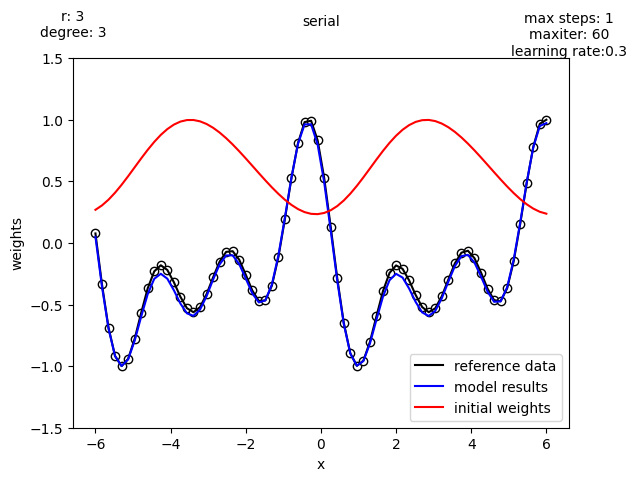

In [ ]:
# Annotate with extra information
extra_info = f'r: {r}\ndegree: {degree}'
plt.annotate(extra_info, xy=(0, 1.05), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')
extra_info = 'serial'
plt.annotate(extra_info, xy=(0.5, 1.1), xycoords='axes fraction', fontsize=10, ha='center', va='center')


extra_info = f'max steps: {max_steps}\nmaxiter: {maxiter}\nlearning rate:{lr}'
plt.annotate(extra_info, xy=(1, 1), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')



plt.plot(x, target_y, c='black', label = 'reference data')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue', label = 'model results')
plt.plot(x, init_weights, c='r', label = 'initial weights')
plt.ylim(-degree/2, degree/2)
# Add labels and a legend
plt.xlabel('x')
plt.ylabel('weights')
plt.legend()

directory_path = "./part1/Freq_Graphs"
create_File(directory_path)
plt.savefig("./part1/Freq_Graphs/serial_attributes_r={}_degree={}_step={}_maxiter={}_lr={}.png".format(r, degree,max_steps, maxiter, lr))
plt.show()

TEST STARTS HERE

#x = test_x
#target_y = np.array([target_function(x_) for x_ in x])

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

predictions = [qt.run(weights, x=x_) for x_ in x]


# Annotate with extra information
extra_info = f'r: {r}\ndegree: {degree}'
plt.annotate(extra_info, xy=(0, 1.1), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')
extra_info = 'TEST SERIAL'
plt.annotate(extra_info, xy=(0.5, 1.1), xycoords='axes fraction', fontsize=10, ha='center', va='center')


plt.plot(x, target_y, c='black', label = 'reference data')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue', label = 'model results')
plt.ylim(-(degree/2), (degree/2))
# Add labels and a legend
plt.xlabel('x')
plt.ylabel('weights')
plt.legend()
plt.show()

import os
import ast

def file_exists(file_path):
    return os.path.exists(file_path)

def write_attributes_to_file(attributes, filename):
    # Write each attribute on a new line
    with open(filename, 'w') as file:
        for key, value in attributes.items():
            file.write(f"{key}: {value}\n")
        file.write("*")

def add_to_beginning(file_path, new_element):
    # Read existing content
    with open(file_path, 'r') as file:
        content = file.read()

    # Write each attribute on a new line
    with open(file_path, 'w') as file:
        for key, value in new_element.items():
            file.write(f"{key}: {value}\n")
        file.write("*")
        file.write(content)
        

def read_attributes_from_file(filename):
    # Read attributes from a file where each attribute is on a new line
    attributes = {}
    with open(filename, 'r') as file:
        for line in file:
            # Check if the line contains the delimiter
            if ':' in line:
                key, value = line.strip().split(': ', 1)
                attributes[key] = value
            else:
                # Handle lines without the delimiter (optional)
                print(f"Skipping line without delimiter: {line.strip()}")
    return attributes


def read_first_attribute_from_file(filename):
    # Read the first attribute from a file and rewind the cursor
    attributes = {}
    with open(filename, 'r') as file:
        line = file.readline().strip()
        key, value = line.split(': ')
        attributes[key] = value
        file.seek(0)  # Rewind the cursor to the beginning of the file
    return attributes


file_name = 'attributes.txt'

if file_exists(file_name):
    num_it = read_first_attribute_from_file(file_name)
    print("num it")
    print(num_it['number_of_iteration'])
    # Example usage
    attributes_to_store = {
        'number_of_iteration' : int(num_it['number_of_iteration'])+1,
        'init_weights': init_weights,
        'predictions': predictions,
        'target_y': target_y,
        'degree' : degree
    }

    # Write attributes to the file
    add_to_beginning(new_element=attributes_to_store, file_path=file_name)
else:
    # Example usage
    attributes_to_store = {
        'number_of_iteration' : 1,
        'init_weights': init_weights,
        'predictions': predictions,
        'target_y': target_y,
        'degree' : degree
    }
    write_attributes_to_file(attributes_to_store, file_name)




# Read attributes from the file
read_attributes = read_attributes_from_file(file_name)

# Print the read attributes
print("Read attributes:", read_attributes)


In [ ]:
"""
from qiskit import QuantumCircuit, Aer, execute
from qiskit.utils import QuantumInstance
from qiskit.visualization import circuit_drawer
from qiskit.visualization import plot_bloch_multivector


class QDevice:
    def __init__(self, backend, wires=1):
        self.backend = backend
        self.quantum_instance = QuantumInstance(backend, shots=1024)
        self.wires = wires
    
        self.qc = QuantumCircuit(self.wires, self.wires)
    
    def run(self, weights, x=None):
        self.qc = QuantumCircuit(self.wires, self.wires)
        for theta in weights[:-1]:
            self.W(theta)
            self.S(x)
        
        # L+1'th unitary
        self.W(weights[-1])
        
        return self.observe_wire(wires=0)
    
    #Used to observe the wires equivalent of qml.expval(qml.PauliZ)
    #Should change to more general version of Pauli matrix as observable
    def observe_wire(self, wires=0, observable=(QuantumCircuit.z, 0)):
        self.qc.z(0)
        result = execute(self.qc, self.backend).result()
        statevector = result.get_statevector()

        # Compute the expectation value of the Pauli-Z operator
        pauli_z_eigenvalues = np.zeros(2 ** self.wires)
        pauli_z_eigenvalues[wires] = 1
        
        # Compute the expectation value of the Pauli-Z operator
        expectation_value = np.conj(statevector) @ pauli_z_eigenvalues  # Pauli-Z eigenvalues
        return expectation_value
        
    #Need to do more general implementation with the possibility of choosing gates
    def S(self, x, wires=0):
        """Data encoding circuit block."""
        self.qc.rx(scaling*x, wires)
    
    def W(self, theta, wires=0):
        """Trainable circuit block."""
        # Is it same with the pennylane? Because qc.u uses unitaries only
        self.qc.u(theta[0], theta[1], theta[2], wires)
        
    def draw(self):
        # Draw the circuit
        diagram = circuit_drawer(self.qc, output='text')
        print(diagram)
    
qt = QDevice(Aer.get_backend('statevector_simulator'), 1)
#qt.run([[1,2,3]])
#qt.draw()
"""


SyntaxError: invalid syntax (1470557727.py, line 44)

from qiskit.algorithms.optimizers import ADAM as AdamOptimizer
from scipy.optimize import minimize

def cost(weights, x, y):
    #print("Weights in cost func: {}".format(weights))
    weights=np.reshape(weights, w_shape)
    #print("REWeights in cost func: {}".format(weights.shape))

    predictions = [qt.run(weights, x=x_) for x_ in x]
    return square_loss(y, predictions)

w_shape = weights.shape

max_steps = 2
opt = AdamOptimizer(maxiter=1000, lr=0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    #print("Shape of x: {}".format(x_batch.shape))
    #print("Shape of y: {}".format(y_batch.shape))
    #print("Shape of w: {}".format(np.sum(weights,axis=1)))
    
    # Update the weights by one optimizer step
    res = opt.minimize(lambda w: cost(w, x_batch, y_batch), weights.reshape(-1))

    weights = res.x

    #print("Weights after minimize {}".format(weights))

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    #if (step + 1) % 10 == 0:
    print("Cost at step {0:3}: {1}".format(step + 1, c))
    